In [1]:
import os
import sys
import numpy as np
from os.path import join
from os.path import basename
from tqdm import tqdm
from tabulate import tabulate
from collections import Counter
from feature_analyzer.data_tools.embedding_container import EmbeddingContainer
from feature_analyzer.data_tools.result_container import ResultContainer

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
root_dir = '/home/kv_zhao/nist-e2e/feature-analyzer'
feat_dir = join(root_dir, 'examples')
resvar_dir = join(root_dir, 'results_variance')

In [3]:
ec1_name = 'featobj_mergeV1_iv3_D60kv2_noaug_CL003'
ec2_name = 'featobj_mergeV1_iv3_D60kv2_noaug_RM'
ec3_name = 'featobj_mergeV1_iv3_D60kv2_noaug_RMG'
ec4_name = 'featobj_mergeV1_iv3_D60kv2_noaug_RMG_GS'
ec5_name = 'featobj_mergeV1_iv3_D60kv2_noaug_RMG2p_GS_final'
ec6_name = 'featobj_mergeV1_iv3_D60kv2_noaug_RSEMG2p_GS'
# embeddings
ec1 = EmbeddingContainer(name=ec1_name)
ec2 = EmbeddingContainer(name=ec2_name)
ec3 = EmbeddingContainer(name=ec3_name)
ec4 = EmbeddingContainer(name=ec4_name)
ec5 = EmbeddingContainer(name=ec5_name)
ec6 = EmbeddingContainer(name=ec6_name)
# results
rc1 = ResultContainer()
rc2 = ResultContainer()
rc3 = ResultContainer()
rc4 = ResultContainer()
rc5 = ResultContainer()
rc6 = ResultContainer()

Container:featobj_mergeV1_iv3_D60kv2_noaug_CL003 created
Container:featobj_mergeV1_iv3_D60kv2_noaug_RM created
Container:featobj_mergeV1_iv3_D60kv2_noaug_RMG created
Container:featobj_mergeV1_iv3_D60kv2_noaug_RMG_GS created
Container:featobj_mergeV1_iv3_D60kv2_noaug_RMG2p_GS_final created
Container:featobj_mergeV1_iv3_D60kv2_noaug_RSEMG2p_GS created


In [4]:
namemap = {
    ec1_name: 'CL003',
    ec2_name: 'RM',
    ec3_name: 'RMG',
    ec4_name: 'RMG*',
    ec5_name: 'RMG2p*',
    ec6_name: 'RSEMG2p*',
}

In [47]:
model_names = [
    ec1_name,
    ec2_name,
    ec3_name,
    ec4_name,
    ec5_name,
    ec6_name
]

In [5]:
ec1.load(join(feat_dir, ec1_name))
ec2.load(join(feat_dir, ec2_name))
ec3.load(join(feat_dir, ec3_name))
ec4.load(join(feat_dir, ec4_name))
ec5.load(join(feat_dir, ec5_name))
ec6.load(join(feat_dir, ec6_name))

Load embedding container from feat_obj format
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/embeddings.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/label_ids.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/filename_strings.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/probabilities.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/label_names.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/landmarks.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/instance_ids.npy is loaded
container size: 10000 -> 134117
embedding size: 0 -> 512
probability size: 0 -> 1
landmark size: 0 -> 10
Reset featobj_mergeV1_iv3_D60kv2_noaug_CL003
Ind

In [6]:
rc1.load(join(resvar_dir, 'var_mergeV1_iv3_D60kv2_noaug_CL003'))
rc2.load(join(resvar_dir, 'var_mergeV1_iv3_D60kv2_noaug_RM'))
rc3.load(join(resvar_dir, 'var_mergeV1_iv3_D60kv2_noaug_RMG'))
rc4.load(join(resvar_dir, 'var_mergeV1_iv3_D60kv2_noaug_RMG_GS'))
rc5.load(join(resvar_dir, 'var_mergeV1_iv3_D60kv2_noaug_RMG2p_GS_final'))
rc6.load(join(resvar_dir, 'var_mergeV1_iv3_D60kv2_noaug_iv3_RSEMG2p_GS'))

In [7]:
# Align three label_ids
def get_labelmap(container):
    inst_ids = container.instance_ids
    lids = container.get_label_by_instance_ids(inst_ids)
    lns = container.get_label_name_by_instance_ids(inst_ids)
    labelmap = {l: n for l, n in zip(lids, lns)}
    return labelmap

In [8]:
def get_class_attribute(container):
    inst_ids = container.instance_ids
    lids = container.get_label_by_instance_ids(inst_ids)
    lns = container.get_label_name_by_instance_ids(inst_ids)
    attrs = container.get_attribute_by_instance_ids(inst_ids)
    attrmap = {l: {
        'label_id': l,
        'name': n['identity_name'],
        'src': n['source'],
        'folder': f,
    } for l, f, n in zip(lids, lns, attrs)}
    return attrmap

In [9]:
ec1_labelmap = get_labelmap(ec1)
ec2_labelmap = get_labelmap(ec2)
ec3_labelmap = get_labelmap(ec3)
ec4_labelmap = get_labelmap(ec4)
ec5_labelmap = get_labelmap(ec5)
ec6_labelmap = get_labelmap(ec6)

In [89]:
ec6_labelmap = get_labelmap(ec6)

In [91]:
ec1_labelmap == ec2_labelmap == ec3_labelmap == ec4_labelmap == ec5_labelmap == ec6_labelmap

True

In [11]:
labelmap = ec1_labelmap
num_total_classes = len(labelmap)
num_total_instances = len(ec1.instance_ids)
print(num_total_classes, num_total_instances)

7474 134117


In [12]:
num_instance_for_label_id = {
    label_id: len(ec1.get_instance_ids_by_label(label_id)) for label_id in list(set(ec1.label_ids))}

In [13]:
attrmap = get_class_attribute(ec1)

In [14]:
dataset = pd.DataFrame.from_dict(attrmap, orient='index')
dataset['num_instance'] = dataset.apply(lambda x: num_instance_for_label_id[int(x.label_id)], axis=1)

In [15]:
dataset

,label_id,name,src,folder,num_instance
0,0,Dave_Vescio,CASIA,2057822,3
1,1,Ayuko_Izumi,CASIA,6305385,5
2,2,"""Dan_Bárta""",VGG,n001889,26
3,3,Ang Lee,MS1M,m.0h1p,43
4,4,0258360,,0258360,8
...,...,...,...,...,...
7469,7469,Lee Seung-gi,MS1M,m.049grkn,20
7470,7470,Alexandra_Godinez,CASIA,4893225,2
7471,7471,Anna the Prophetess,MS1M,m.0329l4,2
7472,7472,"""Günther_Jauch""",VGG,n003283,104


In [16]:
def get_foundation(container, results, labelmap):
    events = results.events
    purity_events = events[events.topk_purity == 1.0]
    foundation_events = purity_events[purity_events.last_pos_sim >= 1.5]
    foundation_classes = []
    label_ids = list(map(int, foundation_events.label_id.unique()))
    num_instance_for_label_id = {
        label_id: len(container.get_instance_ids_by_label(label_id)) for label_id in label_ids}
    for label_id in label_ids:
        num_margin_event = len(foundation_events[foundation_events.label_id == label_id])
        if num_margin_event == num_instance_for_label_id[label_id]:
            foundation_classes.append(label_id)
    return foundation_events, foundation_classes

In [129]:
def seperate_type(container, results, attrmap):
    events = results.events
    events['folder_name'] = events.apply(lambda x: attrmap[int(x.label_id)]['folder'], axis=1)
    t1 = events[events.topk_purity == 1.0]
    t2 = events[events.topk_purity != 1.0]
    return t1, t2

In [18]:
def _percent(num_target, num_total):
    _str = '{}/{} ({:.2f}%)'.format(
        num_target,
        num_total,
        100 * (num_target / (num_total + 1e-8))
    )
    return _str

In [19]:
m1_fd_events, m1_fd_classes = get_foundation(ec1, rc1, labelmap)
m2_fd_events, m2_fd_classes = get_foundation(ec2, rc2, labelmap)
m3_fd_events, m3_fd_classes = get_foundation(ec3, rc3, labelmap)
m4_fd_events, m4_fd_classes = get_foundation(ec4, rc4, labelmap)
m5_fd_events, m5_fd_classes = get_foundation(ec5, rc5, labelmap)
m6_fd_events, m6_fd_classes = get_foundation(ec6, rc6, labelmap)

In [92]:
headerlist = ['Model', '#of Foundation Events', '#of Founcation Classes']
tablelist = [
    [namemap[ec1_name], len(m1_fd_events), len(m1_fd_classes)],
    [namemap[ec2_name], len(m2_fd_events), len(m2_fd_classes)],
    [namemap[ec3_name], len(m3_fd_events), len(m3_fd_classes)],
    [namemap[ec4_name], len(m4_fd_events), len(m4_fd_classes)],
    [namemap[ec5_name], len(m5_fd_events), len(m5_fd_classes)],
    [namemap[ec6_name], len(m6_fd_events), len(m6_fd_classes)],
]
table = tabulate(tablelist, headerlist)
print(table)

Model       #of Foundation Events    #of Founcation Classes
--------  -----------------------  ------------------------
CL003                       82180                      4156
RM                          82809                      4218
RMG                         86468                      4450
RMG*                        86492                      4427
RMG2p*                      86910                      4463
RSEMG2p*                    88861                      4535


## Foundation Events & Classes

In [93]:
headerlist = ['Model', '#of Foundation Events', '#of Founcation Classes']
tablelist = [
    [namemap[ec1_name], _percent(len(m1_fd_events), num_total_instances), _percent(len(m1_fd_classes), num_total_classes)],
    [namemap[ec2_name], _percent(len(m2_fd_events), num_total_instances), _percent(len(m2_fd_classes), num_total_classes)],
    [namemap[ec3_name], _percent(len(m3_fd_events), num_total_instances), _percent(len(m3_fd_classes), num_total_classes)],
    [namemap[ec4_name], _percent(len(m4_fd_events), num_total_instances), _percent(len(m4_fd_classes), num_total_classes)],
    [namemap[ec5_name], _percent(len(m5_fd_events), num_total_instances), _percent(len(m5_fd_classes), num_total_classes)],
    [namemap[ec6_name], _percent(len(m6_fd_events), num_total_instances), _percent(len(m6_fd_classes), num_total_classes)],
]
table = tabulate(tablelist, headerlist)
print(table)

Model     #of Foundation Events    #of Founcation Classes
--------  -----------------------  ------------------------
CL003     82180/134117 (61.27%)    4156/7474 (55.61%)
RM        82809/134117 (61.74%)    4218/7474 (56.44%)
RMG       86468/134117 (64.47%)    4450/7474 (59.54%)
RMG*      86492/134117 (64.49%)    4427/7474 (59.23%)
RMG2p*    86910/134117 (64.80%)    4463/7474 (59.71%)
RSEMG2p*  88861/134117 (66.26%)    4535/7474 (60.68%)


In [22]:
common_fd_classes = list(
    set(m1_fd_classes) & set(m2_fd_classes) & set(m3_fd_classes) & set(m4_fd_classes))

In [23]:
print(len(common_fd_classes))

3671


In [24]:
common_fd_class_nums = np.asarray([num_instance_for_label_id[_id] for _id in common_fd_classes])
print(np.mean(common_fd_class_nums), np.median(common_fd_class_nums))
print(np.sum(common_fd_class_nums > 11))

9.716426041950422 5.0
941


In [25]:
def foundation_class_statistics(fd_classes):
    fd_class_nums = np.asarray([num_instance_for_label_id[_id] for _id in fd_classes])
    print(np.mean(fd_class_nums), np.median(fd_class_nums))
    print(np.sum(fd_class_nums > 11))

In [94]:
foundation_class_statistics(common_fd_classes)
foundation_class_statistics(m1_fd_classes)
foundation_class_statistics(m2_fd_classes)
foundation_class_statistics(m3_fd_classes)
foundation_class_statistics(m4_fd_classes)
foundation_class_statistics(m5_fd_classes)
foundation_class_statistics(m6_fd_classes)

9.716426041950422 5.0
941
10.370307988450433 6.0
1170
10.720483641536273 6.0
1208
11.183595505617978 6.0
1365
11.251185904675852 6.0
1368
11.083352005377549 6.0
1367
11.371334068357221 6.0
1419


In [27]:
common_fd_class_srcs = [
    attrmap[label]['src'] for label in common_fd_classes
]
print(Counter(common_fd_class_srcs) )

Counter({'CASIA': 1561, 'VGG': 891, '': 680, 'MS1M': 539})


In [28]:
common_fd_class_names = [
    attrmap[label]['folder'] for label in common_fd_classes
]

In [130]:
m1t1, m1t2 = seperate_type(ec1, rc1, attrmap)
m2t1, m2t2 = seperate_type(ec2, rc2, attrmap)
m3t1, m3t2 = seperate_type(ec3, rc3, attrmap)
m4t1, m4t2 = seperate_type(ec4, rc4, attrmap)
m5t1, m5t2 = seperate_type(ec5, rc5, attrmap)
m6t1, m6t2 = seperate_type(ec6, rc6, attrmap)

In [185]:
t1_events = [
    m1t1,
    m2t1,
    m3t1,
    m4t1,
    m5t1,
    m6t1,
]

In [132]:
t2_events = [
    m1t2,
    m2t2,
    m3t2,
    m4t2,
    m5t2,
    m6t2,
]

In [186]:
common_t1_instance_ids = set(ec1.instance_ids)
for e in t1_events:
    common_t1_instance_ids &= set(e.instance_id)
common_t1_instance_ids = list(common_t1_instance_ids)
print(len(common_t1_instance_ids))
print(len(common_t1_instance_ids) / num_total_instances)

107767
0.8035297538716195


In [182]:
common_t2_instance_ids = set(ec1.instance_ids)
for e in t2_events:
    common_t2_instance_ids &= set(e.instance_id)
common_t2_instance_ids = list(common_t2_instance_ids)
print(len(common_t2_instance_ids))
print(len(common_t2_instance_ids) / num_total_instances)

10561
0.07874467815414898


## Type I & II Distribution

In [30]:
headerlist = ['Model', 'Foundation', 'Type I', 'Type II']
tablelist = [
    [namemap[ec1_name], _percent(len(m1_fd_events),num_total_instances), _percent(len(m1t1),num_total_instances), _percent(len(m1t2),num_total_instances)],
    [namemap[ec2_name], _percent(len(m2_fd_events),num_total_instances), _percent(len(m2t1),num_total_instances), _percent(len(m2t2),num_total_instances)],
    [namemap[ec3_name], _percent(len(m3_fd_events),num_total_instances), _percent(len(m3t1),num_total_instances), _percent(len(m3t2),num_total_instances)],
    [namemap[ec4_name], _percent(len(m4_fd_events),num_total_instances), _percent(len(m4t1),num_total_instances), _percent(len(m4t2),num_total_instances)],
    [namemap[ec5_name], _percent(len(m5_fd_events),num_total_instances), _percent(len(m5t1),num_total_instances), _percent(len(m5t2),num_total_instances)],
    [namemap[ec6_name], _percent(len(m6_fd_events),num_total_instances), _percent(len(m6t1),num_total_instances), _percent(len(m6t2),num_total_instances)],
]
table = tabulate(tablelist, headerlist)
print(table)

Model     Foundation             Type I                  Type II
--------  ---------------------  ----------------------  ---------------------
CL003     82180/134117 (61.27%)  113977/134117 (84.98%)  20140/134117 (15.02%)
RM        82809/134117 (61.74%)  116550/134117 (86.90%)  17567/134117 (13.10%)
RMG       86468/134117 (64.47%)  117880/134117 (87.89%)  16237/134117 (12.11%)
RMG*      86492/134117 (64.49%)  117941/134117 (87.94%)  16176/134117 (12.06%)
RMG2p*    86910/134117 (64.80%)  118511/134117 (88.36%)  15606/134117 (11.64%)
RSEMG2p*  88861/134117 (66.26%)  119083/134117 (88.79%)  15034/134117 (11.21%)


## Type I Spectrum

In [31]:
sim_ranges = [(2.0, 1.5), (1.5, 1.45), (1.45, 1.4), (1.4, 1.3), (1.3, 0.9)]
headerlist = ['Model', '[2.0, 1.5]', '[1.5, 1.45]', '[1.45, 1.4]', '[1.4, 1.3]', '[1.3, 0.9]']
tablelist = []
for name, events in zip([ec1_name, ec2_name, ec3_name, ec4_name, ec5_name, ec6_name], [m1t1, m2t1, m3t1, m4t1, m5t1, m6t1]):
    vals = [namemap[name]]
    for r in sim_ranges:
        sim_in_between= events[events.last_pos_sim.between(r[1], r[0])]
        vals.append(_percent(len(sim_in_between), num_total_instances))
        #vals.append('{}/{} ({:02.5f})'.format(len(sim_in_between), num_total_instances, len(sim_in_between) / num_total_instances))
    tablelist.append(vals)
table = tabulate(tablelist, headerlist)
print(table)

Model     [2.0, 1.5]             [1.5, 1.45]            [1.45, 1.4]           [1.4, 1.3]           [1.3, 0.9]
--------  ---------------------  ---------------------  --------------------  -------------------  -----------------
CL003     82178/134117 (61.27%)  17616/134117 (13.13%)  10684/134117 (7.97%)  3497/134117 (2.61%)  0/134117 (0.00%)
RM        82809/134117 (61.74%)  17308/134117 (12.91%)  11052/134117 (8.24%)  5362/134117 (4.00%)  21/134117 (0.02%)
RMG       86468/134117 (64.47%)  16271/134117 (12.13%)  10243/134117 (7.64%)  4882/134117 (3.64%)  16/134117 (0.01%)
RMG*      86490/134117 (64.49%)  16333/134117 (12.18%)  10282/134117 (7.67%)  4824/134117 (3.60%)  10/134117 (0.01%)
RMG2p*    86910/134117 (64.80%)  16198/134117 (12.08%)  10499/134117 (7.83%)  4895/134117 (3.65%)  9/134117 (0.01%)
RSEMG2p*  88861/134117 (66.26%)  15851/134117 (11.82%)  9800/134117 (7.31%)   4554/134117 (3.40%)  17/134117 (0.01%)


In [32]:
sim_ranges = [(2.0, 1.45), (1.45, 1.4), (1.4, 1.3), (1.3, 0.9)]
headerlist = ['Model', '[2.0, 1.45]', '[1.45, 1.4]', '[1.4, 1.3]', '[1.3, 0.9]']
tablelist = []
for name, events in zip([ec1_name, ec2_name, ec3_name, ec4_name, ec5_name, ec6_name], [m1t1, m2t1, m3t1, m4t1, m5t1, m6t1]):
    vals = [namemap[name]]
    for r in sim_ranges:
        sim_in_between= events[events.last_pos_sim.between(r[1], r[0])]
        vals.append(_percent(len(sim_in_between), num_total_instances))
        #vals.append('{}/{} ({:02.5f})'.format(len(sim_in_between), num_total_instances, len(sim_in_between) / num_total_instances))
    tablelist.append(vals)
table = tabulate(tablelist, headerlist)
print(table)

Model     [2.0, 1.45]             [1.45, 1.4]           [1.4, 1.3]           [1.3, 0.9]
--------  ----------------------  --------------------  -------------------  -----------------
CL003     99794/134117 (74.41%)   10684/134117 (7.97%)  3497/134117 (2.61%)  0/134117 (0.00%)
RM        100115/134117 (74.65%)  11052/134117 (8.24%)  5362/134117 (4.00%)  21/134117 (0.02%)
RMG       102739/134117 (76.60%)  10243/134117 (7.64%)  4882/134117 (3.64%)  16/134117 (0.01%)
RMG*      102823/134117 (76.67%)  10282/134117 (7.67%)  4824/134117 (3.60%)  10/134117 (0.01%)
RMG2p*    103108/134117 (76.88%)  10499/134117 (7.83%)  4895/134117 (3.65%)  9/134117 (0.01%)
RSEMG2p*  104712/134117 (78.08%)  9800/134117 (7.31%)   4554/134117 (3.40%)  17/134117 (0.01%)


## Common Type I Spectrum

In [187]:
#Common Type I distribution
sim_ranges = [(2.0, 1.45), (1.45, 1.4), (1.4, 1.3), (1.3, 0.9)]
headerlist = ['Model', '[2.0, 1.45]', '[1.45, 1.4]', '[1.4, 1.3]', '[1.3, 0.9]']
tablelist = []
for name, _t1_events in zip([ec1_name, ec2_name, ec3_name, ec4_name, ec5_name, ec6_name], [m1t1, m2t1, m3t1, m4t1, m5t1, m6t1]):
    vals = [namemap[name]]
    for r in sim_ranges:
        events = _t1_events[_t1_events.instance_id.isin(common_t1_instance_ids)]
        sim_in_between= events[events.last_pos_sim.between(r[1], r[0])]
        vals.append(_percent(len(sim_in_between), len(common_t1_instance_ids)))
        #vals.append('{}/{} ({:02.5f})'.format(len(sim_in_between), num_total_instances, len(sim_in_between) / num_total_instances))
    tablelist.append(vals)
table = tabulate(tablelist, headerlist)
print(table)

Model     [2.0, 1.45]             [1.45, 1.4]          [1.4, 1.3]           [1.3, 0.9]
--------  ----------------------  -------------------  -------------------  ----------------
CL003     97442/107767 (90.42%)   8249/107767 (7.65%)  2074/107767 (1.92%)  0/107767 (0.00%)
RM        97783/107767 (90.74%)   7720/107767 (7.16%)  2260/107767 (2.10%)  4/107767 (0.00%)
RMG       99201/107767 (92.05%)   6814/107767 (6.32%)  1751/107767 (1.62%)  1/107767 (0.00%)
RMG*      99188/107767 (92.04%)   6813/107767 (6.32%)  1764/107767 (1.64%)  0/107767 (0.00%)
RMG2p*    99277/107767 (92.12%)   6794/107767 (6.30%)  1695/107767 (1.57%)  1/107767 (0.00%)
RSEMG2p*  100491/107767 (93.25%)  5907/107767 (5.48%)  1369/107767 (1.27%)  0/107767 (0.00%)


In [108]:
def get_last_pos_instance_ids(event):
    event['last_pos_instance_id'] = event.apply(
        lambda x: x.ret_ids[int(x.last_pos_index)], axis=1)
    return event

In [106]:
cases = m6t1[m6t1.last_pos_sim.between(0.9, 1.3)]
cases = get_last_pos_instance_ids(cases)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [109]:
cases.last_pos_instance_id

3689        3678
13214      13235
13251      13258
18324      18304
29219      29238
32136      32128
40544      40530
75061      75068
75063      75068
75064      75068
78348      78344
86202      86204
90630      90642
100666    100671
104286    104274
105535    105529
110651    110630
Name: last_pos_instance_id, dtype: int64

In [111]:
_inst_ids = list(m6t1[m6t1.last_pos_sim.between(0.9, 1.3)].instance_id)
print(ec6.get_filename_strings_by_instance_ids(_inst_ids))
_filenames = ec6.get_filename_strings_by_instance_ids(list(cases.last_pos_instance_id))
print(_filenames)

['n007227/0083_01.jpg', 'n001783/0129_01.jpg', 'n001783/0003_01.jpg', 'n009291/0126_01.jpg', 'n004793/0717_01.jpg', 'n008432/0297_02.jpg', 'm.04wqr/123_FaceId-0.jpg', 'n000433/0334_01.jpg', 'n000433/0482_01.jpg', 'n000433/0041_01.jpg', 'n003637/0181_01.jpg', 'n006775/0334_01.jpg', 'n000732/0141_01.jpg', 'm.01d1yr/75_FaceId-0.jpg', 'n009283/0313_01.jpg', 'n002190/0288_01.jpg', 'n005080/0404_01.jpg']
['n007227/0205_04.jpg', 'n001783/0422_01.jpg', 'n001783/0490_01.jpg', 'n009291/0192_03.jpg', 'n004793/0404_01.jpg', 'n008432/0494_01.jpg', 'm.04wqr/15_FaceId-0.jpg', 'n000433/0111_01.jpg', 'n000433/0111_01.jpg', 'n000433/0111_01.jpg', 'n003637/0253_01.jpg', 'n006775/0169_01.jpg', 'n000732/0026_02.jpg', 'm.01d1yr/60_FaceId-0.jpg', 'n009283/0026_01.jpg', 'n002190/0319_01.jpg', 'n005080/0159_06.jpg']


In [33]:
# IN CLASS
sim_ranges = [(2.0, 1.5), (1.5, 1.45), (1.45, 1.4), (1.4, 1.3), (1.3, 0.9)]
headerlist = ['Model', '[2.0, 1.5]', '[1.5, 1.45]', '[1.45, 1.4]', '[1.4, 1.3]', '[1.3, 0.9]']
tablelist = []
for name, events in zip([ec1_name, ec2_name, ec3_name, ec4_name, ec5_name, ec6_name], [m1t1, m2t1, m3t1, m4t1, m5t1, m6t1]):
    vals = [namemap[name]]
    for r in sim_ranges:
        sim_in_between= events[events.last_pos_sim.between(r[1], r[0])]
        vals.append('{}'.format(len(sim_in_between.label_id.unique())))
    tablelist.append(vals)
table = tabulate(tablelist, headerlist)
print(table)

Model       [2.0, 1.5]    [1.5, 1.45]    [1.45, 1.4]    [1.4, 1.3]    [1.3, 0.9]
--------  ------------  -------------  -------------  ------------  ------------
CL003             6712           2715           1987          1125             0
RM                6692           2666           1945          1266            16
RMG               6732           2455           1827          1165            12
RMG*              6731           2492           1826          1166             8
RMG2p*            6754           2471           1824          1135             9
RSEMG2p*          6796           2427           1728          1093            14


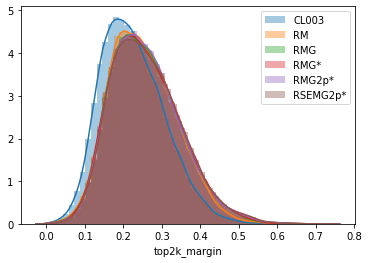

In [34]:
sns.distplot(m1_fd_events.top2k_margin)
sns.distplot(m2_fd_events.top2k_margin)
sns.distplot(m3_fd_events.top2k_margin)
sns.distplot(m4_fd_events.top2k_margin)
sns.distplot(m5_fd_events.top2k_margin)
sns.distplot(m6_fd_events.top2k_margin)
plt.legend(labels=[
    namemap[ec1_name],
    namemap[ec2_name],
    namemap[ec3_name],
    namemap[ec4_name],
    namemap[ec5_name],
    namemap[ec6_name],
])

In [54]:
# margin statistics
for name, event in zip(model_names, t1_events):
    print('{}: mean = {:.4f}, std = {:.4f}, median = {:.4f}'.format(namemap[name],
                                                                    np.mean(event.top2k_margin),
                                                                    np.std(event.top2k_margin),
                                                                    np.median(event.top2k_margin),
                                                                   ))

CL003: mean = 0.1826, std = 0.1012, median = 0.1763
RM: mean = 0.2036, std = 0.1080, median = 0.1986
RMG: mean = 0.2115, std = 0.1110, median = 0.2070
RMG*: mean = 0.2114, std = 0.1112, median = 0.2065
RMG2p*: mean = 0.2130, std = 0.1114, median = 0.2082
RSEMG2p*: mean = 0.2166, std = 0.1122, median = 0.2115


In [35]:
sample = m4t2.iloc[11]
print(sample)

class_ap                                                          0.999869
class_margin                                                   -0.00345278
class_purity                                                      0.988636
extend_diversity                                                        37
first_neg_index                                                         86
first_neg_sim                                                      1.37695
first_sim                                                          1.80135
instance_id                                                            128
label_id                                                                 6
last_neg_sim                                                       1.24865
last_pos_index                                                          87
last_pos_sim                                                        1.3735
num_topk                                                                87
ret_ids                  

In [36]:
# finally, all retrieved
np.sum(sample.ret_label_ids == sample.label_id) == sample.num_topk

True

In [37]:
sample.ret_label_ids[1:3]

array([6, 6])

In [158]:
def all_retrieved(t2):
    t2['all_fetched'] = t2.apply(
        lambda x: np.sum(x.ret_label_ids == x.label_id) == x.num_topk,
        axis=1)
    t2nf = t2[~t2.all_fetched]
    t2f = t2[t2.all_fetched]
    print('#of out of search: {} ({})'.format(len(t2) - len(t2f), (len(t2) - len(t2f))/len(t2)))
    t2f['n_outlier'] = t2f.apply(lambda x: np.sum(x.ret_label_ids[int(2 * x.num_topk):] == x.label_id), axis=1)
    t2f['n_within_2k'] = t2f.apply(lambda x: np.sum(x.ret_label_ids[int(x.num_topk): int(2 * x.num_topk)+1] == x.label_id), axis=1)
    return t2f, t2nf

In [159]:
m1t2f, m1t2nf = all_retrieved(m1t2)
m2t2f, m2t2nf = all_retrieved(m2t2)
m3t2f, m3t2nf = all_retrieved(m3t2)
m4t2f, m4t2nf = all_retrieved(m4t2)
m5t2f, m5t2nf = all_retrieved(m5t2)
m6t2f, m6t2nf = all_retrieved(m6t2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#of out of search: 134 (0.006653426017874876)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


#of out of search: 177 (0.010075710138327545)
#of out of search: 180 (0.01108579171029131)
#of out of search: 182 (0.011251236399604353)
#of out of search: 206 (0.013200051262335)
#of out of search: 152 (0.010110416389517094)


In [166]:
m6t2nf

,class_ap,class_margin,class_purity,extend_diversity,first_neg_index,first_neg_sim,first_sim,instance_id,label_id,last_neg_sim,...,top2k_first_neg_index,top2k_first_neg_sim,top2k_last_neg_sim,top2k_last_pos_index,top2k_last_pos_sim,top2k_margin,topk_ap,topk_purity,folder_name,all_fetched
3956,1.000000,0.004214,1.000000,12.0,28.0,1.361961,1.776266,3956.0,214.0,0.907479,...,28.0,1.361961,1.291623,27.0,1.366174,0.004214,1.0,0.965517,n008365,False
12521,1.000000,0.310274,1.000000,8.0,13.0,1.308620,1.835714,12521.0,686.0,0.913184,...,13.0,1.308620,1.284010,12.0,1.618894,0.310274,1.0,0.928571,0001662,False
12526,0.077031,-0.365520,0.000122,9.0,1.0,1.305839,1.305839,12526.0,686.0,0.911400,...,1.0,1.305839,1.245395,0.0,2.000000,0.694161,1.0,0.071429,0001662,False
17757,1.000000,0.268391,1.000000,2.0,3.0,1.338048,1.732394,17757.0,985.0,0.907609,...,3.0,1.338048,1.299919,2.0,1.606439,0.268391,1.0,0.750000,1754593,False
17758,0.500025,-0.276015,0.000050,3.0,1.0,1.303792,1.303792,17758.0,985.0,0.904449,...,1.0,1.303792,1.278092,0.0,2.000000,0.696208,1.0,0.250000,1754593,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109689,0.100099,-0.309319,0.000129,8.0,1.0,1.300451,1.300451,109689.0,6122.0,0.913764,...,1.0,1.300451,1.274659,0.0,2.000000,0.699549,1.0,0.090909,n006096,False
114610,0.050159,-0.883000,0.000190,11.0,1.0,1.825919,1.825919,114610.0,6407.0,0.909163,...,1.0,1.825919,1.253963,0.0,2.000000,0.174081,1.0,0.047619,n008384,False
114615,1.000000,0.041852,1.000000,12.0,20.0,1.368830,1.637701,114615.0,6407.0,0.915664,...,20.0,1.368830,1.291639,19.0,1.410682,0.041852,1.0,0.952381,n008384,False
127225,0.691874,-0.411398,0.000629,22.0,38.0,1.381106,1.768014,127225.0,7114.0,0.912808,...,38.0,1.381106,1.269773,110.0,1.271526,-0.109580,1.0,0.655172,n008112,False


In [161]:
m1t2f[(m1t2f.n_within_2k == 0) & (m1t2f.n_outlier > 0)]

,class_ap,class_margin,class_purity,extend_diversity,first_neg_index,first_neg_sim,first_sim,instance_id,label_id,last_neg_sim,...,top2k_last_neg_sim,top2k_last_pos_index,top2k_last_pos_sim,top2k_margin,topk_ap,topk_purity,folder_name,all_fetched,n_outlier,n_within_2k
259,0.952381,-0.068633,0.428571,4.0,11.0,1.398008,1.934332,259.0,14.0,1.124937,...,1.339470,10.0,1.636010,0.238002,1.0,0.916667,m.04glw0x,True,1,0
260,0.950000,-0.070295,0.400000,2.0,11.0,1.412439,1.919239,260.0,14.0,1.126099,...,1.355312,10.0,1.612859,0.200420,1.0,0.916667,m.04glw0x,True,1,0
265,0.925287,-0.138694,0.103448,8.0,11.0,1.406433,1.843791,265.0,14.0,1.125505,...,1.319843,10.0,1.639604,0.233171,1.0,0.916667,m.04glw0x,True,1,0
267,0.943694,-0.070685,0.324324,5.0,11.0,1.391390,1.934332,267.0,14.0,1.121246,...,1.334502,10.0,1.636666,0.245275,1.0,0.916667,m.04glw0x,True,1,0
514,0.888903,-0.334174,0.000124,5.0,8.0,1.328566,1.782369,514.0,29.0,0.906561,...,1.298544,7.0,1.564610,0.236045,1.0,0.888889,n008749,True,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133901,0.888928,-0.308113,0.000352,5.0,8.0,1.384939,1.972260,133901.0,7462.0,0.904459,...,1.325286,7.0,1.753304,0.368365,1.0,0.888889,n001304,True,1,0
133902,0.888918,-0.359177,0.000264,3.0,8.0,1.418784,1.870296,133902.0,7462.0,0.903830,...,1.359579,7.0,1.752325,0.333541,1.0,0.888889,n001304,True,1,0
133903,0.888940,-0.287641,0.000456,7.0,8.0,1.380088,1.972260,133903.0,7462.0,0.906378,...,1.325542,7.0,1.761327,0.381239,1.0,0.888889,n001304,True,1,0
133904,0.889081,-0.217800,0.001727,6.0,8.0,1.369747,1.826114,133904.0,7462.0,0.903352,...,1.331935,7.0,1.689538,0.319790,1.0,0.888889,n001304,True,1,0


In [135]:
headerlist = ['Model', '#of Type II', '#of Within 2k']
tablelist = []
for name, events in zip([ec1_name, ec2_name, ec3_name, ec4_name, ec5_name, ec6_name], [m1t2f, m2t2f, m3t2f, m4t2f, m5t2f, m6t2f]):
    vals = [namemap[name]]
    vals.append(
        _percent(len(events), num_total_instances))
    vals.append(
        _percent(len(events[(events.n_outlier == 0) & (events.n_within_2k > 0)]), num_total_instances))
    tablelist.append(vals)
table = tabulate(tablelist, headerlist)
print(table)

Model     #of Type II            #of Within 2k
--------  ---------------------  --------------------
CL003     20006/134117 (14.92%)  11067/134117 (8.25%)
RM        17390/134117 (12.97%)  9467/134117 (7.06%)
RMG       16057/134117 (11.97%)  8410/134117 (6.27%)
RMG*      15994/134117 (11.93%)  8411/134117 (6.27%)
RMG2p*    15400/134117 (11.48%)  7885/134117 (5.88%)
RSEMG2p*  14882/134117 (11.10%)  7478/134117 (5.58%)


## Type II Cases

In [136]:
headerlist = ['Model', '#of Type II', '#of in Top 2k', '#of all outlier', '#of mixed']
tablelist = []
for name, events in zip([ec1_name, ec2_name, ec3_name, ec4_name, ec5_name, ec6_name], [m1t2f, m2t2f, m3t2f, m4t2f, m5t2f, m6t2f]):
    vals = [namemap[name]]
    in2k = events[(events.n_outlier == 0) & (events.n_within_2k > 0)]
    all_out = events[(events.n_outlier > 0) & (events.n_within_2k == 0)]
    num_of_mixed = len(events) - len(in2k) - len(all_out)
    vals.append(
        _percent(len(events), num_total_instances))
    vals.append(
        _percent(len(in2k), num_total_instances))
    vals.append(
        _percent(len(all_out), num_total_instances))
    vals.append(
        _percent(num_of_mixed, num_total_instances))
    tablelist.append(vals)
table = tabulate(tablelist, headerlist)
print(table)

Model     #of Type II            #of in Top 2k         #of all outlier      #of mixed
--------  ---------------------  --------------------  -------------------  -------------------
CL003     20006/134117 (14.92%)  11067/134117 (8.25%)  5883/134117 (4.39%)  3056/134117 (2.28%)
RM        17390/134117 (12.97%)  9467/134117 (7.06%)   5393/134117 (4.02%)  2530/134117 (1.89%)
RMG       16057/134117 (11.97%)  8410/134117 (6.27%)   5443/134117 (4.06%)  2204/134117 (1.64%)
RMG*      15994/134117 (11.93%)  8411/134117 (6.27%)   5406/134117 (4.03%)  2177/134117 (1.62%)
RMG2p*    15400/134117 (11.48%)  7885/134117 (5.88%)   5463/134117 (4.07%)  2052/134117 (1.53%)
RSEMG2p*  14882/134117 (11.10%)  7478/134117 (5.58%)   5387/134117 (4.02%)  2017/134117 (1.50%)


In [137]:
headerlist = ['Model', '#of Type II', '#of in Top 2k', '#of all outlier']
tablelist = []
for name, events in zip([ec1_name, ec2_name, ec3_name, ec4_name, ec5_name, ec6_name], [m1t2f, m2t2f, m3t2f, m4t2f, m5t2f, m6t2f]):
    vals = [namemap[name]]
    in2k = events[(events.n_outlier == 0) & (events.n_within_2k > 0)].label_id.unique()
    all_out = events[(events.n_outlier > 0) & (events.n_within_2k == 0)].label_id.unique()
    vals.append(
        _percent(len(events.label_id.unique()), num_total_classes))
    vals.append(
        _percent(len(in2k), num_total_classes))
    vals.append(
        _percent(len(all_out), num_total_classes))
    tablelist.append(vals)
table = tabulate(tablelist, headerlist)
print(table)

Model     #of Type II         #of in Top 2k       #of all outlier
--------  ------------------  ------------------  -----------------
CL003     1865/7474 (24.95%)  1623/7474 (21.72%)  722/7474 (9.66%)
RM        1654/7474 (22.13%)  1428/7474 (19.11%)  588/7474 (7.87%)
RMG       1492/7474 (19.96%)  1269/7474 (16.98%)  559/7474 (7.48%)
RMG*      1496/7474 (20.02%)  1269/7474 (16.98%)  571/7474 (7.64%)
RMG2p*    1420/7474 (19.00%)  1201/7474 (16.07%)  546/7474 (7.31%)
RSEMG2p*  1404/7474 (18.79%)  1183/7474 (15.83%)  501/7474 (6.70%)


In [193]:
m1t2f_allout = m1t2f[(m1t2f.n_outlier > 0) & (m1t2f.n_within_2k == 0)]
m2t2f_allout = m2t2f[(m2t2f.n_outlier > 0) & (m2t2f.n_within_2k == 0)]
m3t2f_allout = m3t2f[(m3t2f.n_outlier > 0) & (m3t2f.n_within_2k == 0)]
m4t2f_allout = m4t2f[(m4t2f.n_outlier > 0) & (m4t2f.n_within_2k == 0)]
m5t2f_allout = m5t2f[(m5t2f.n_outlier > 0) & (m5t2f.n_within_2k == 0)]
m6t2f_allout = m6t2f[(m6t2f.n_outlier > 0) & (m6t2f.n_within_2k == 0)]

In [217]:
m1t2f_top2k = m1t2f[(m1t2f.n_outlier == 0) & (m1t2f.n_within_2k > 0)]
m2t2f_top2k = m2t2f[(m2t2f.n_outlier == 0) & (m2t2f.n_within_2k > 0)]
m3t2f_top2k = m3t2f[(m3t2f.n_outlier == 0) & (m3t2f.n_within_2k > 0)]
m4t2f_top2k = m4t2f[(m4t2f.n_outlier == 0) & (m4t2f.n_within_2k > 0)]
m5t2f_top2k = m5t2f[(m5t2f.n_outlier == 0) & (m5t2f.n_within_2k > 0)]
m6t2f_top2k = m6t2f[(m6t2f.n_outlier == 0) & (m6t2f.n_within_2k > 0)]

## Type II - Mixed Top 2k Spectrum

In [224]:
sim_ranges = [(2.0, 1.45), (1.45, 1.4), (1.4, 1.3), (1.3, 1.2), (1.2, 0.9)]
headerlist = ['Model', '[2.0, 1.45]', '[1.45, 1.4]', '[1.4, 1.3]', '[1.3, 1.2]', '[1.2, 0.9]']
tablelist = []
interest_events = [m1t2f_top2k, m2t2f_top2k, m3t2f_top2k, m4t2f_top2k, m5t2f_top2k, m6t2f_top2k]
for name, events in zip(model_names, interest_events):
    vals = [namemap[name]]
    for r in sim_ranges:
        sim_in_between= events[events.top2k_last_pos_sim.between(r[1], r[0])]
        vals.append(_percent(len(sim_in_between), len(common_t1_instance_ids)))
        #vals.append('{}/{} ({:02.5f})'.format(len(sim_in_between), num_total_instances, len(sim_in_between) / num_total_instances))
    tablelist.append(vals)
table = tabulate(tablelist, headerlist)
print(table)

Model     [2.0, 1.45]         [1.45, 1.4]          [1.4, 1.3]           [1.3, 1.2]           [1.2, 0.9]
--------  ------------------  -------------------  -------------------  -------------------  ----------------
CL003     519/107767 (0.48%)  1879/107767 (1.74%)  7875/107767 (7.31%)  794/107767 (0.74%)   0/107767 (0.00%)
RM        422/107767 (0.39%)  1061/107767 (0.98%)  6384/107767 (5.92%)  1600/107767 (1.48%)  0/107767 (0.00%)
RMG       328/107767 (0.30%)  902/107767 (0.84%)   5748/107767 (5.33%)  1432/107767 (1.33%)  0/107767 (0.00%)
RMG*      330/107767 (0.31%)  907/107767 (0.84%)   5770/107767 (5.35%)  1404/107767 (1.30%)  0/107767 (0.00%)
RMG2p*    285/107767 (0.26%)  827/107767 (0.77%)   5380/107767 (4.99%)  1393/107767 (1.29%)  0/107767 (0.00%)
RSEMG2p*  320/107767 (0.30%)  754/107767 (0.70%)   5179/107767 (4.81%)  1225/107767 (1.14%)  0/107767 (0.00%)


In [233]:
m6_hardfp_events = m6t2f_top2k[m6t2f_top2k.top2k_last_pos_sim.between(1.4, 2.0)]
print(len(m6_hardfp_events))

1074


In [242]:
m6_hardfp_events.folder_name.value_counts()

n003979      51
n003508      46
n000608      45
n002724      42
n000341      34
             ..
0516804       1
n009259       1
m.02px3w3     1
n001142       1
n002411       1
Name: folder_name, Length: 470, dtype: int64

In [138]:
m1t2f_m = m1t2f[m1t2f.top2k_margin > 0]
m2t2f_m = m2t2f[m2t2f.top2k_margin > 0]
m3t2f_m = m3t2f[m3t2f.top2k_margin > 0]
m4t2f_m = m4t2f[m4t2f.top2k_margin > 0]
m5t2f_m = m5t2f[m5t2f.top2k_margin > 0]
m6t2f_m = m6t2f[mt2f.top2k_margin > 0]

In [139]:
sim_ranges = [(2.0, 1.5), (1.5, 1.45), (1.45, 1.4), (1.4, 1.3), (1.3, 0.9)]
headerlist = ['Model', '[2.0, 1.5]', '[1.5, 1.45]', '[1.45, 1.4]', '[1.4, 1.3]', '[1.3, 0.9]']
tablelist = []
for name, events in zip([ec1_name, ec2_name, ec3_name, ec4_name, ec5_name, ec6_name], [m1t2f_m, m2t2f_m, m3t2f_m, m4t2f_m, m5t2f_m, m6t2f_m]):
    vals = [namemap[name]]
    for r in sim_ranges:
        sim_in_between= events[events.top2k_last_pos_sim.between(r[1], r[0])]
        vals.append(_percent(len(sim_in_between), num_total_instances))
        #vals.append('{}/{} ({:02.5f})'.format(len(sim_in_between), num_total_instances, len(sim_in_between) / num_total_instances))
    tablelist.append(vals)
table = tabulate(tablelist, headerlist)
print(table)

Model     [2.0, 1.5]           [1.5, 1.45]          [1.45, 1.4]         [1.4, 1.3]          [1.3, 0.9]
--------  -------------------  -------------------  ------------------  ------------------  ----------------
CL003     3128/134117 (2.33%)  1048/134117 (0.78%)  839/134117 (0.63%)  405/134117 (0.30%)  0/134117 (0.00%)
RM        2927/134117 (2.18%)  889/134117 (0.66%)   780/134117 (0.58%)  446/134117 (0.33%)  3/134117 (0.00%)
RMG       3084/134117 (2.30%)  813/134117 (0.61%)   787/134117 (0.59%)  449/134117 (0.33%)  2/134117 (0.00%)
RMG*      2985/134117 (2.23%)  827/134117 (0.62%)   785/134117 (0.59%)  456/134117 (0.34%)  0/134117 (0.00%)
RMG2p*    3111/134117 (2.32%)  817/134117 (0.61%)   738/134117 (0.55%)  491/134117 (0.37%)  3/134117 (0.00%)
RSEMG2p*  3171/134117 (2.36%)  825/134117 (0.62%)   711/134117 (0.53%)  428/134117 (0.32%)  3/134117 (0.00%)


## Common Type II Study

In [256]:
common_t2_instance_ids = list(map(int, list(set(m1t2f.instance_id) & set(m2t2f.instance_id) & set(m4t2f.instance_id) & set(m5t2f.instance_id) & set(m6t2f.instance_id))))
print(len(common_t2_instance_ids))

10491


In [249]:
m1ct2f = m1t2f[m1t2f.instance_id.isin(common_t2_instance_ids)]
m2ct2f = m2t2f[m2t2f.instance_id.isin(common_t2_instance_ids)]
m3ct2f = m3t2f[m3t2f.instance_id.isin(common_t2_instance_ids)]
m4ct2f = m4t2f[m4t2f.instance_id.isin(common_t2_instance_ids)]
m5ct2f = m5t2f[m5t2f.instance_id.isin(common_t2_instance_ids)]
m6ct2f = m6t2f[m6t2f.instance_id.isin(common_t2_instance_ids)]

In [252]:
m1ct2f_allout = m1ct2f[(m1ct2f.n_outlier > 0) & (m1ct2f.n_within_2k == 0)]
m2ct2f_allout = m2ct2f[(m2ct2f.n_outlier > 0) & (m2ct2f.n_within_2k == 0)]
m3ct2f_allout = m3ct2f[(m3ct2f.n_outlier > 0) & (m3ct2f.n_within_2k == 0)]
m4ct2f_allout = m4ct2f[(m4ct2f.n_outlier > 0) & (m4ct2f.n_within_2k == 0)]
m5ct2f_allout = m5ct2f[(m5ct2f.n_outlier > 0) & (m5ct2f.n_within_2k == 0)]
m6ct2f_allout = m6ct2f[(m6ct2f.n_outlier > 0) & (m6ct2f.n_within_2k == 0)]

In [250]:
m1ct2f_top2k = m1ct2f[(m1ct2f.n_outlier == 0) & (m1ct2f.n_within_2k > 0)]
m2ct2f_top2k = m2ct2f[(m2ct2f.n_outlier == 0) & (m2ct2f.n_within_2k > 0)]
m3ct2f_top2k = m3ct2f[(m3ct2f.n_outlier == 0) & (m3ct2f.n_within_2k > 0)]
m4ct2f_top2k = m4ct2f[(m4ct2f.n_outlier == 0) & (m4ct2f.n_within_2k > 0)]
m5ct2f_top2k = m5ct2f[(m5ct2f.n_outlier == 0) & (m5ct2f.n_within_2k > 0)]
m6ct2f_top2k = m6ct2f[(m6ct2f.n_outlier == 0) & (m6ct2f.n_within_2k > 0)]